# Analyse dispersion data for Inversion

This notebook loads features extracted from the gradient of the A0 and S0 modes in the simulated FEA data from Abaqus. The feature extraction for this takes place in the postprocess_2dfft_max script. The following things should be done in the following:
1. load data with dataloader from database. For this, all `.._feature.txt` files and respective `.._info.json` files need to be in one folder. The feature files are loaded in parallel with their info file (contains ground truth thickness) in an ascending order by name.
2. Shape loaded input data so that it can be processed from sklearn. This means the features are feed into a matrix X with shape (| n_samples, - n_features) and the ground truth thicknesses into a vector y with size (| n_samples). Later on it might make sense to choose a certain thickness as threshold and label every sample which is thinner as 'too thin' and every sample which is thicker than 'thick enough', i.e. make the regression problem a classification problem.
3. Feed data into regressor and figure out some performance measure for each classifier (precision, accuracy, recall, ...). Maybe use cross-validation for this.

At the very end, this notebook should help to show that machine learning algorithms are somewhat better than chance. In this case, a more sophisticated approach like Convolutional Neural Networks (CNNs) may be used.

Import modules:

In [1]:
import numpy as np
from pathlib import Path
import matplotlib

In [ ]:
# comment out the following if you do not want to export to latex
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
%load_ext autoreload
%autoreload 2

## Import Data

Load/preprocess data and extract features. All features are loaded into a matrix `X` of shape (`n_samples`, `n_features`) and the associated thickness labels are loaded into a vector `y` of shape (`n_samples`).

There are currently two data sets available:
- `'lin'` with `n_features` = 2, since function for fitting had shape
$f_{fit}(x)=a x + b$.
- `'lin_simple'` with `n_features` = 1, since function for fitting had shape
$f_{fit}(x)=a x$.

In [3]:
from analysis_sklearn.dispersion_feature_loader import get_filenames, load_data_from_files
from sklearn.preprocessing import MinMaxScaler

fig_path = Path.cwd() / 'figures'

Specify if plots should be saved in a way to be exported to Latex

In [4]:
save_publication = True

In [5]:
def load_X_y_data(feature_name):
    data_path = Path().parent.resolve() / 'data' / feature_name

    filenames = get_filenames(data_path)
    X, y = load_data_from_files(filenames, data_path)
    y = y * 1E6

    sort_idx = np.argsort(y.ravel())
    X = np.array([X[i, :] for i in sort_idx])
    y = np.array([y.ravel()[i] for i in sort_idx])
    return X, y

Combine lin (locally created) and lin_cluster (created on cluster) data **(jump to next
cell if this is not what I want to use here)**:

In [6]:
X1, y1 = load_X_y_data('lin')

X2, y2 = load_X_y_data('lin_cluster')

if True:
    # last three elements look like outlier
    X2 = X2[0:-3, :]
    y2 = y2[0:-3]

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)


sort_idx = np.argsort(y.ravel())
X = np.array([X[i, :] for i in sort_idx])
y = np.array([y.ravel()[i] for i in sort_idx])
y_reg = np.copy(y)

print(y)
print(f'There are {len(y)} elements in the data set.')

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'C:\\Users\\Max\\OneDrive - Georgia Institute of Technology\\Documents\\Uni Gatech MSC\\A Lab Research Wave CEE\\python_scripts\\analysis_sklearn\\data\\lin_cluster'

Load fully locally created dataset from all data:

In [6]:
X, y = load_X_y_data('lin_local_thesis')  # 'lin_local_v1', 'lin_local_v3'lin_local_in_range'
y_reg = np.copy(y)

# X, y = X[39:56,:], y[39:56]

print(y[52])
print(f'There are {len(y)} elements in the data set.')

260.0
There are 134 elements in the data set.


Visualize loaded dataset's thickness distribution

In [7]:
plt.figure()
_,_,_ = plt.hist(y, bins=60, density=False, facecolor='purple')
plt.title('Coating thickness distribution')
plt.xlabel(r'Coating thickness in $\mu$m')
plt.ylabel('Number of simulations')
if False:
    plt.savefig(fig_path / '11092021_Thickness_distribution_htc.png', dpi=400)
plt.show()

<ipython-input-7-45595ecbd1cf>:8: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [8]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

### Try different regressors/classifiers on the data set

The most interesting and important part is to show that a machine learning algorithm is able to predict the thickness with an accuracy that is somehow better than chance now. An alternative to the regressor is classification into 'thick enough' and 'not thick enough'. For this binary classification problem y needs to be converted via

$y_{i,new} = \begin{cases}
    1,& \text{if } y_i > \text{threshold}\\
    0              & \text{otherwise}
\end{cases}
$

First let us convert y into a vector with only binary class labels ('thick enough' = 1 and 'not thick enough' = 0)


In [9]:
# print(y)
assert np.max(y) != 1, 'y already converted to binary class!'
threshold = 200 #190 #210
y = [1 if i > threshold else 0 for i in y]
# print(y)

In [10]:
# Statistics of dataset:
print(f'thick enough: {sum(y)} = {100 * sum(y)/len(y)}% out of {len(y)}')


thick enough: 97 = 72.38805970149254% out of 134


### Visualize data and features first:

In [12]:
c_labels = ['g' if elem == 1 else 'r' for elem in np.copy(y)]
l_labels = ['not thick enough' if elem == 1 else 'thick enough' for elem in y]

plt.figure(dpi=300)
for idx, x in enumerate(X[0:np.argmax(y)-1]):
    plt.scatter(x[0], x[1], c=c_labels[idx], alpha=0.3)
plt.scatter(X[np.argmax(y)-1,0], X[np.argmax(y)-1,1], c='r', label='not thick enough', alpha=0.7)
plt.scatter(X[np.argmax(y),0], X[np.argmax(y),1], c='g', label='thick enough', alpha=0.7)
for idx, x in enumerate(X[np.argmax(y)+1::]):
    plt.scatter(x[0], x[1], c=c_labels[np.argmax(y)+1+idx], alpha=0.1)
if not save_publication:
    plt.title('Feature Plot for Dispersion inversion\nFitted function has shape $f(x) = a*x+b$')
plt.xlabel(r'$a$ (gradient of fit)')
plt.ylabel(r'$b$ (y-intercept of fit)')
# plt.axis([0.8,1,0,1])
plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
if False:
    plt.savefig(fig_path / '11092021_Scatter_with_gap_data_htc.png', dpi=400)
if save_publication:
    pub_out_name = f'feature_plot_uniform_dispersion_v2.pgf'
    plt.savefig(fig_path / pub_out_name, backend='pgf', format='pgf', dpi=50)
if not save_publication:
    plt.show()

# plt.figure(dpi=200)
# for x in np.arange(52,53):
#     plt.scatter(X[x,0], X[x,1], label=y_reg[x])
# plt.title('Feature Plot for Dispersion inversion\nFitted function has shape $f(x) = a*x+b$')
# plt.xlabel('a (gradient of fit)')
# plt.ylabel('b (y-intercept of fit)')
# plt.axis([-0.1,1,0,1.1])
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show()
#
# print(y[52])

Try the same as above but change markers

In [13]:
c_labels = ['g' if elem == 1 else 'r' for elem in np.copy(y)]
l_labels = ['not thick enough' if elem == 1 else 'thick enough' for elem in y]

plt.figure(dpi=300)

for idx, x in enumerate(X[0:np.argmax(y)-1]):
    plt.scatter(x[0], x[1], c=c_labels[idx], marker='o', alpha=0.4)
plt.scatter(X[np.argmax(y)-1,0], X[np.argmax(y)-1,1], c='r',
            label='not thick enough', marker='o', alpha=0.7)


plt.scatter(X[np.argmax(y),0], X[np.argmax(y),1], c='g',
            label='thick enough', marker='D', alpha=0.7)
for idx, x in enumerate(X[np.argmax(y)+1::]):
    plt.scatter(x[0], x[1], c=c_labels[np.argmax(y)+1+idx], marker='D', alpha=0.2)

if not save_publication:
    plt.title('Feature Plot for Dispersion inversion\nFitted function has shape $f(x) = a*x+b$')
plt.xlabel(r'$a$ (gradient of fit)')
plt.ylabel(r'$b$ (y-intercept of fit)')
# plt.axis([0.8,1,0,1])
plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
if False:
    plt.savefig(fig_path / '11092021_Scatter_with_gap_data_htc.png', dpi=400)
if save_publication:
    pub_out_name = f'feature_plot_uniform_dispersion_v2.pgf'
    plt.savefig(fig_path / pub_out_name, backend='pgf', format='pgf', dpi=50)
    plt.savefig(fig_path / str(pub_out_name[0:-3] + 'png'), backend='pgf', format='png', dpi=200)
if not save_publication:
    plt.show()

No handles with labels found to put in legend.


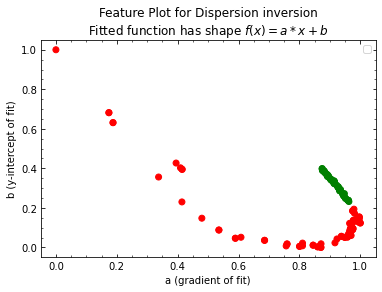

In [12]:
# double check plot
fig = plt.figure()

Axes = plt.subplot(1,1,1)
Axes.axes.tick_params(which='both', direction='in', top=True, right=True)
plt.minorticks_on()
plt.scatter(X[:,0], X[:,1], c=c_labels)
plt.title('Feature Plot for Dispersion inversion\nFitted function has shape $f(x) = a*x+b$')
plt.xlabel('a (gradient of fit)')
plt.ylabel('b (y-intercept of fit)')
plt.legend()

## Load sklearn modules now and start machine learning:

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Perceptron

Split data into train and test data. If test_size within [0,1] then proportion is selected, if test_size is an int the number of test samples is used.

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [15]:
nearestNeighbors = 1
knn = KNeighborsClassifier(n_neighbors=nearestNeighbors)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

nearestNeighbors = 5
knn5 = KNeighborsClassifier(n_neighbors=nearestNeighbors)
knn5.fit(X_train,y_train)
y_pred_knn5 = knn5.predict(X_test)

lsvm = SVC(kernel="linear", C=6)
lsvm.fit(X_train,y_train)
y_pred_lsvm = lsvm.predict(X_test)

# rbfsvm = SVC(gamma=2, kernel='rbf', C=5)
rbfsvm = SVC(gamma=2, kernel='rbf', C=4)
rbfsvm.fit(X_train,y_train)
y_pred_rbfsvm = rbfsvm.predict(X_test)

gp = GaussianProcessClassifier(1.0 * RBF(50.0))
gp.fit(X_train, y_train)
y_pred_gp = gp.predict(X_test)

# nn = MLPClassifier(
#     hidden_layer_sizes=(80,70,50),
#     max_iter=300,
#     activation = 'relu',
#     solver='adam',
#     random_state=1
# )
# nn = MLPClassifier(
#     hidden_layer_sizes=(40,500,1000,2000,1300),#(80,70,50),
#     max_iter=1000,
#     activation = 'relu',
#     solver='adam',
#     random_state=1,
#     alpha=0.0002
# )
nn = MLPClassifier(
    hidden_layer_sizes=(40,100,30),#(80,70,50),
    max_iter=500,
    activation = 'relu',
    solver='adam',
    random_state=1,
    alpha=0.0008
)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)

perceptron = Perceptron(
    penalty='l2',
    alpha=0.0005,
)
perceptron.fit(X, y)
y_pred_perceptron = perceptron.predict(X_test)

# print(knn.predict(X_test))
# print(f'true values: {y_test}')
print(f'1NN accuracy = {accuracy_score(y_test, y_pred_knn)}')
print(f'5NN accuracy = {accuracy_score(y_test, y_pred_knn5)}')
print(f'Linear SVM accuracy = {accuracy_score(y_test, y_pred_lsvm)}')
print(f'RBF SVM accuracy = {accuracy_score(y_test, y_pred_rbfsvm)}')
print(f'GP Network accuracy = {accuracy_score(y_test, y_pred_gp)}')
print(f'Neural Network accuracy = {accuracy_score(y_test, y_pred_nn)}')
print(f'Perceptron accuracy = {accuracy_score(y_test, y_pred_perceptron)}')

1NN accuracy = 1.0
5NN accuracy = 0.9777777777777777
Linear SVM accuracy = 0.9777777777777777
RBF SVM accuracy = 0.9777777777777777
GP Network accuracy = 0.8222222222222222
Neural Network accuracy = 0.9777777777777777
Perceptron accuracy = 0.9777777777777777


### Conduct cross-validation for hyperparameter tuning:

In [16]:
from sklearn.model_selection import cross_val_score

folds = 5
# knn_scores = cross_val_score(knn, X, y, cv=folds)
# knn5_scores = cross_val_score(knn5, X, y, cv=folds)
lsvm_scores = cross_val_score(lsvm, X, y, cv=folds)
rbfsvm_scores = cross_val_score(rbfsvm, X, y, cv=folds)
# gp_scores = cross_val_score(gp, X, y, cv=folds)
# nn_scores = cross_val_score(nn, X, y, cv=folds)
# perceptron_scores = cross_val_score(perceptron, X, y, cv=folds)

# print(f'knn: {knn_scores.mean()} accuracy with a standard deviation of {knn_scores.std()}')
# print(f'knn5: {knn5_scores.mean()} accuracy with a standard deviation of {knn5_scores.std()}')
print(f'lsvm: {lsvm_scores.mean()} accuracy with a standard deviation of {lsvm_scores.std()}')
print(f'rbfsvm: {rbfsvm_scores.mean()} accuracy with a standard deviation of {rbfsvm_scores.std()}')
# print(f'gp: {gp_scores.mean()} accuracy with a standard deviation of {gp_scores.std()}')
# print(f'nn: {nn_scores.mean()} accuracy with a standard deviation of {nn_scores.std()}')
# print(f'perceptron: {perceptron_scores.mean()} accuracy with a standard deviation of {perceptron_scores.std()}')

lsvm: 0.947008547008547 accuracy with a standard deviation of 0.06629305787919766
rbfsvm: 0.9544159544159545 accuracy with a standard deviation of 0.06126349882947287


## Try and visualize different classifiers

Select the classifier which should be evaluated and comment out all other classifiers in `cla`.

In [15]:
my_colors = [(1, 0, 0),(0.4, 1, 0.2)]
my_cm = LinearSegmentedColormap.from_list('my_cm', my_colors, N=2)

In [30]:
cla = [
    # 'knn1',
    # 'knn5',
    # 'perceptron',
    # 'svc_lin',
    # 'svc_rbf',
    # 'gp',
    'mlp'
]

if 'knn1' in cla:
    nearestNeighbors = 1
    clf = KNeighborsClassifier(n_neighbors=nearestNeighbors)
    clf.fit(X, y)

if 'knn5' in cla:
    nearestNeighbors = 5
    clf = KNeighborsClassifier(n_neighbors=nearestNeighbors)
    clf.fit(X, y)

if 'perceptron' in cla:
    clf = Perceptron(
        penalty='l2',
        alpha=0.0005,
    )
    clf.fit(X, y)

if 'svc_lin' in cla:
    clf = SVC(kernel="linear", C=200)
    clf.fit(X,y)

if 'svc_rbf' in cla:
    clf = SVC(gamma=2, kernel='rbf', C=4)
    clf.fit(X_train,y_train)

if cla == 'gp':
    clf = GaussianProcessClassifier(50.0 * RBF(20.5))
    clf.fit(X_train, y_train)

if 'mlp' in cla:
    clf = MLPClassifier(
        hidden_layer_sizes=(20,50,30),#(40,500,1000,2000,1300),#(80,70,50),
        max_iter=500,
        activation = 'relu',
        solver='adam',
        random_state=1,
        alpha=0.0001
    )
    clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [31]:
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
C = np.c_[x_mesh.ravel(),y_mesh.ravel()]

predicted_labels = clf.predict(C)


NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Visualize decision regions

In [32]:
x_coords = x_mesh.ravel()
y_coords = y_mesh.ravel()
thick_enough_region_x = x_coords[predicted_labels==1]
thick_enough_region_y = y_coords[predicted_labels==1]
not_thick_enough_region_x = x_coords[predicted_labels==0]
not_thick_enough_region_y = y_coords[predicted_labels==0]

plt.plot(not_thick_enough_region_x, not_thick_enough_region_y, 'o')
plt.plot(thick_enough_region_x, thick_enough_region_y, 'rs')
plt.title('Decision Regions')

Text(0.5, 1.0, 'Decision Regions')

#### Visualize  classifier with decision boundaries and data set

In [33]:
fig = plt.figure(dpi=500)
fig.set_size_inches(w=3, h=3)
plt.contourf(x_mesh,y_mesh,predicted_labels.reshape(100,100),
             levels=[-1,0,1], cmap = my_cm, alpha=0.4)
plt.contour(x_mesh,y_mesh,predicted_labels.reshape(100,100),linewidths=0.5,colors='k')

# plt.scatter(X[:,0], X[:,1], c=c_labels, alpha=0.4, s=15)
mrks = ['D' if elem == 1 else 'o' for elem in np.copy(y)]
for idx in range(len(mrks)):
    plt.scatter(X[idx,0], X[idx,1], c=c_labels[idx], marker=mrks[idx], alpha=0.4, s=15)

# plt.title(f'{cla[0]} decision regions\nFitted function has shape $f(x) = a*x+b$')
plt.xlabel(r'$a$ (gradient of fit)')
plt.ylabel(r'$b$ (y-intercept of fit)')
if False:
    plt.savefig(f'{cla[0]} for 1D dispersion data_v2.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
if save_publication:
    pub_out_name = f'{cla[0]}_2D_dispersion_data_v2.pgf'#fig_path / pub_out_name
    plt.savefig(fig_path / pub_out_name, backend='pgf', format='pgf', dpi=50, bbox_inches='tight')
    plt.savefig(fig_path / str(pub_out_name[0:-3] + 'png'), backend='pgf',
                format='png', dpi=200, bbox_inches='tight')

In [13]:
# fig = plt.figure(frameon=False, dpi=600)
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# # ax = plt.gca()
# ax.set_axis_off()
# fig.add_axes(ax)
# ax.plot([1,2,3],[1,2,3])

### Compare all Classifiers together

Besides trying and testing the classifiers separably, I will train, test and visualize them together now in the following code snipped.

C:\Users\Max\OneDrive - Georgia Institute of Technology\Documents\Uni Gatech MSC\A Lab Research Wave CEE\python_scripts\env\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


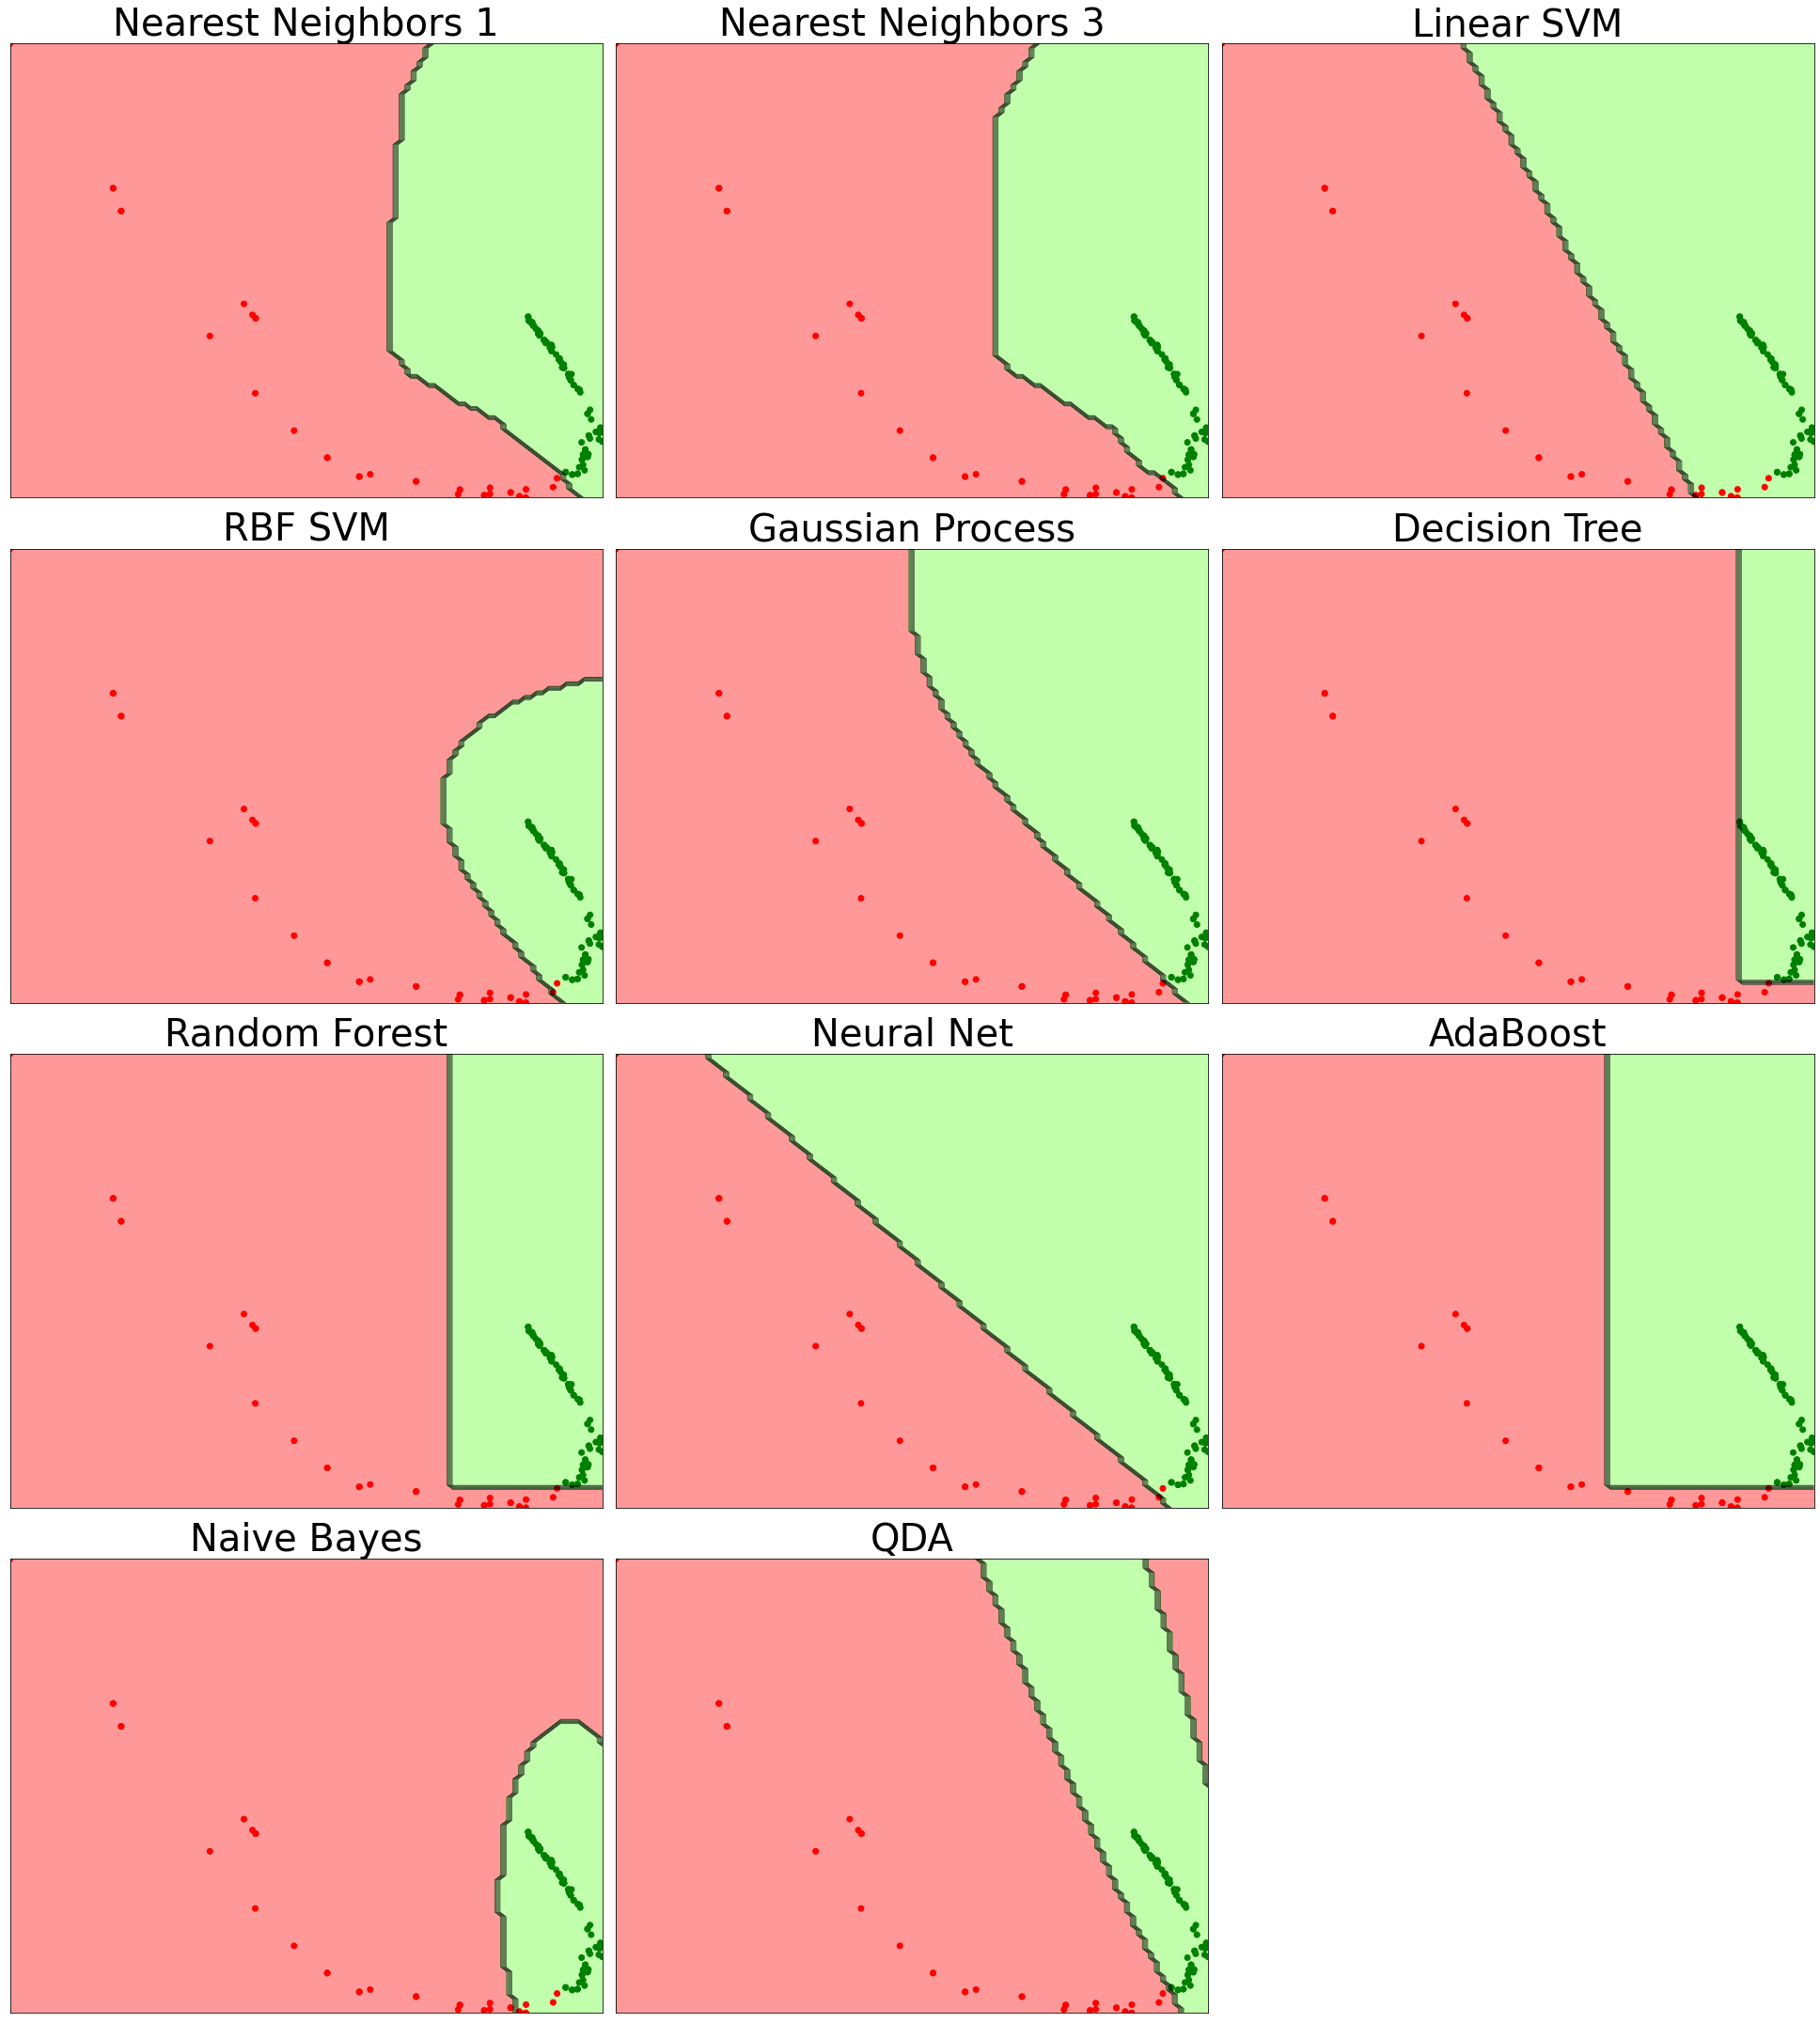

In [23]:
names = ["Nearest Neighbors 1",
         "Nearest Neighbors 3",
         "Linear SVM",
         "RBF SVM",
         "Gaussian Process",
         "Decision Tree",
         "Random Forest",
         "Neural Net",
         "AdaBoost",
         "Naive Bayes",
         "QDA"
         ]

classifiers = [
    KNeighborsClassifier(1),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=1),
    SVC(gamma=6, kernel='rbf', C=5),
    GaussianProcessClassifier(500.0 * RBF(20.5)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1,hidden_layer_sizes=(80,70,50),
                  max_iter=600, activation = 'relu', solver='adam',
                  random_state=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]
grid_res = 100
x_grid = np.linspace(0, 1, grid_res)
y_grid = np.linspace(0, 1, grid_res)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
C = np.c_[x_mesh.ravel(),y_mesh.ravel()]

figure = plt.figure(figsize=(27, 30))

for i, (name, clf) in enumerate(zip(names, classifiers)):
    clf.fit(X, y)
    predicted_labels = clf.predict(C)

    x_coords = x_mesh.ravel()
    y_coords = y_mesh.ravel()
    thick_enough_region_x = x_coords[predicted_labels==1]
    thick_enough_region_y = y_coords[predicted_labels==1]
    not_thick_enough_region_x = x_coords[predicted_labels==0]
    not_thick_enough_region_y = y_coords[predicted_labels==0]

    ax = plt.subplot(4,3,i+1)

    ax.contourf(x_mesh,y_mesh,predicted_labels.reshape(grid_res,grid_res),
             levels=[-1,0,1], cmap = my_cm, alpha=0.4)
    ax.contour(x_mesh,y_mesh,predicted_labels.reshape(grid_res,grid_res),linewidths=0.5,colors='k')
    ax.scatter(X[:,0], X[:,1], c=c_labels)
    ax.set_title(name, fontsize=40)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

plt.tight_layout()
if False:
    plt.savefig(fig_path / '11092021_compare_all_classifiers_with_Gap_v1.png')
